# Interacting with data through the CubeViz application

We first start the the application in the CubeViz configuration.

In [1]:
# Suppress warnings
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
from astropy.utils.data import download_file

from jdaviz.app import Application
app = Application(configuration='cubeviz')
app

/Users/nearl/projects/glue/glue/external/echo/__init__.py:3: UserWarning: glue.external.echo is deprecated, import from echo directly instead
  warnings.warn('glue.external.echo is deprecated, import from echo directly instead')


Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

Next, we load an IFU cube data set. **Note** this does not yet auto-populate viewers, still investigtating heuristics on how to associate particular data sets with particular viewers.

In [3]:
# This file is originally from https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/7495/stack/manga-7495-12704-LOGCUBE.fits.gz
# but has been modified to correct some inconsistencies in the way units are parsed
fn = download_file('https://stsci.box.com/shared/static/28a88k1qfipo4yxc4p4d40v4axtlal8y.fits', cache=True)
app.load_data(fn)

Before we can continue on, we manually set the data within each viewer. After having done that, we can gain access to the viewer of interest by the reference defined in the CubeViz `yaml` configuration file. In this case, we've defined each viewer as follows:


```
...
viewer_area:
  - container: col
    children:
      - container: row
        viewers:
          - name: Flux
            plot: g-image-viewer
            reference: flux-viewer
          - name: Uncertainty
            plot: g-image-viewer
            reference: uncert-viewer
          - name: Mask
            plot: g-image-viewer
            reference: mask-viewer
      - container: row
        viewers:
          - name: Spectrum
            plot: g-profile-viewer
            reference: spectrum-viewer
```

Note the `reference` keyword that associated the viewer with a user-readable string name.

Then, we can access the indivial viewer objects through the `get_viewer` method on the `app` instance:

<div class="alert alert-block alert-info">
<b>User Task:</b> In the top left viewer in the CubeViz application (our `flux-viewer`), open the "Data" tab and plot the "6de4c8ee5659e87a302e3de595074ba5[FLUX]" data set by clicking the checkbox.
</div>

In [4]:
app.get_viewer('spectrum-viewer').show()

Html(children=[Toolbar(children=[ToolbarItems(children=[BasicJupyterToolbar(borderless=True, children=[Tooltip…

We now load the data into the spectrum viewer manually using the current API by calling `set_viewer_data` and passing the viewer reference and data label.

In [20]:
app.add_viewer_data('spectrum-viewer', '6de4c8ee5659e87a302e3de595074ba5[FLUX]')

To retrieve particular data from a viewer, we use the `get_data` method, passing in the reference to the viewer of interest. Optionally, we can pass in a class that will be used in the conversion from the `glue` data objects. If no `cls` argument is set, it will fall back to the `default_class` attribute set on the viewer. In the case of the `cubeviz-spectrum-viewer`, this is a `Spectrum1D` object.

Note that this returns all data currently plotted in the viewer.

In [8]:
from specutils import Spectrum1D

spec_data = app.get_data_from_viewer('spectrum-viewer')

# The returned data from `get_data` is in list format, as it's 
# possible for there to be several data plotted in the viewer
spec = spec_data[0]
spec

<Spectrum1D(flux=<Quantity [0.06278672, 0.05465561, 0.0680534 , ..., 0.03141097, 0.05135   ,
           0.        ] 1e-17 erg / (Angstrom cm2 s)>, spectral_axis=<SpectralCoord [3.62159598e-07, 3.62242998e-07, 3.62326418e-07, ...,
                1.03490386e-06, 1.03514218e-06, 1.03538056e-06] m, 
	radial_velocity=0.0 km / s, 
	redshift=0.0, 
	doppler_rest=0.0 Angstrom, 
	doppler_convention=None, 
	observer=None, 
	target=None>)>

Optionally, we can specify the label explicitly in the `get_viewer_data` call to retrieve a specific layer.

In [10]:
spec = app.get_data_from_viewer('spectrum-viewer', '6de4c8ee5659e87a302e3de595074ba5[FLUX]')
spec

<Spectrum1D(flux=<Quantity [0.06278672, 0.05465561, 0.0680534 , ..., 0.03141097, 0.05135   ,
           0.        ] 1e-17 erg / (Angstrom cm2 s)>, spectral_axis=<SpectralCoord [3.62159598e-07, 3.62242998e-07, 3.62326418e-07, ...,
                1.03490386e-06, 1.03514218e-06, 1.03538056e-06] m, 
	radial_velocity=0.0 km / s, 
	redshift=0.0, 
	doppler_rest=0.0 Angstrom, 
	doppler_convention=None, 
	observer=None, 
	target=None>)>

We then import some analysis or manipulation fuction we want to perform over the extracted spectral data in the previous cell.

In [11]:
from specutils.manipulation import box_smooth

smoothed_spec = box_smooth(spec, 5)

Once we have the results from our manipulation/analysis function, we can insert the data into the appropriate viewer using the `add_data` method on the `app` object and passing in the requisite viewer reference.

In [12]:
# This is necessary since the wcs is not being auto-linked in the manga data. If
#  we don't unset the previous data set, the new data won't be shown on the plot.
app.remove_viewer_data('spectrum-viewer', '6de4c8ee5659e87a302e3de595074ba5[FLUX]')

In [13]:
app.add_data(smoothed_spec, name="Smooth Spectrum")

In [14]:
app.add_viewer_data('spectrum-viewer', 'Smooth Spectrum')

## Retriving manipulated data products

Here, we'll go back up to the CubeViz application and use the collapse plugin to create a 2D data product from within the application. Afterward, we plot it in the `flux-viewer` viewer and then we can retrieve and view the data below in both the glue-jupyter image viewer as well as retrieving and the data and showing it in a matplotlib plot.

<div class="alert alert-block alert-info">
<b>User Task:</b> In the CubeViz application at the top, select the "Collapse" button in the toolbar and collapse the "6de4c8ee5659e87a302e3de595074ba5[FLUX]" data set along the 0th axis to create a 2D image.
    
Next, in the top-left viewer (our `flux-viewer`), uncheck any currently plotted data and scroll to the bottom to click the checkbox next to "Collapsed manga-7495-12704-LOGCUBE[FLUX]" to plot the 2D image.
</div>

In [15]:
# Show the current flux viewer
app.get_viewer('flux-viewer').show()

Html(children=[Toolbar(children=[ToolbarItems(children=[BasicJupyterToolbar(borderless=True, children=[Tooltip…

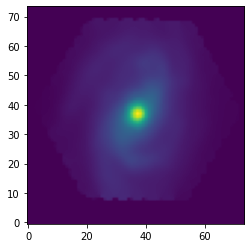

In [19]:
import matplotlib.pyplot as plt

# The returned data object is a `CCData` class to represent the 2D nature of the image data.
image_data = app.get_data_from_viewer('flux-viewer')

f, ax = plt.subplots()

ax.imshow(image_data[0], origin='center')